# PolyG Results

The scripts "cor_interpatient.R", "cor_batch1.R", and "cor_batch2.R" need to be run before this step.

## Loading data and pre-processing

In [2]:
# loading dependencies
library(tidyverse)
library(ggpubr)
library(ggbeeswarm)
library(rstatix)
library(ggrepel)

### Correlation measurement

In [3]:
# loading cor data 
batch1_cor  <- read_tsv("../results/batch1_cor.tsv")  %>% 
    mutate(cohort="Intrapatient MGH")

batch2_cor  <- read_tsv("../results/batch2_cor.tsv")  %>% 
    mutate(cohort="Intrapatient MGH") %>% 
    filter(patient!="CC001")

interpatient_cor <- read_tsv("../results/interpatient_cor.tsv")  %>% 
    mutate(cohort="Interpatient MGH")


Rows: 8 Columns: 4
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (3): a, b, patient
dbl (1): cor

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 73 Columns: 4
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (3): a, b, patient
dbl (1): cor

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 443 Columns: 4
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (2): a, b
dbl (2): cor, markers

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
# combing both tables
cor_combined <- bind_rows(batch1_cor, batch2_cor, interpatient_cor)

### Annotating sequencing based classification

In [5]:
cor_annotated <- cor_combined %>%
        mutate("NGS \nClassification" = case_when(
                cohort == "Interpatient MGH" ~ "Interpatient MGH",
                patient == "CC001" ~ "NA",
                patient == "CC002" ~ "mosaic",
                patient == "CC003" ~ "independent",
                patient == "CC005" ~ "independent",
                patient == "WGS00B" ~ "mosaic",
                patient == "WGS00C" ~ "mosaic",
                patient == "WGS00D" ~ "metastatic",
                patient == "WGS00E" ~ "mosaic",
                patient == "T790M" & str_detect(a, "70[7-9]$|713$") ~ "independent",
                patient == "T790M" & str_detect(b, "70[7-9]$|713$") ~ "independent",
                TRUE ~ "metastatic"
        ))

#### Plotting with Interpatient Cor values

Patient numbers:

In [6]:
 cor_annotated  %>% 
    filter(str_detect(cohort, "MGH"), `NGS \nClassification`!="independent", patient!="CC001"|is.na(patient))  %>% 
    mutate(`NGS \nClassification`=case_when(`NGS \nClassification`=="Interpatient MGH"~ "Unrelated", 
                                            `NGS \nClassification`=="mosaic" ~ "Mosaic",
                                            `NGS \nClassification`=="metastatic" ~ "Metastatic",
                                         TRUE ~ `NGS \nClassification`))  %>% 
    mutate(
        `NGS \nClassification` = as.factor(`NGS \nClassification`),
        `NGS \nClassification` =
            fct_relevel(`NGS \nClassification`, list("Unrelated", "Mosaic", "Metastatic"))
    ) %>%
        ungroup() %>% 
        count(`NGS \nClassification`)

NGS Classification,n
<fct>,<int>
Unrelated,443
Mosaic,7
Metastatic,29


Getting p-values for plot by first performing Kruskal-Wallis test and then Dunn's test if K.W. test is significant.  

In [7]:
sig_kw <- cor_annotated  %>% 
    filter(str_detect(cohort, "MGH"), `NGS \nClassification`!="independent", patient!="CC001"|is.na(patient))  %>% 
    mutate(`NGS \nClassification`=case_when(`NGS \nClassification`=="Interpatient MGH"~ "Unrelated", 
                                            `NGS \nClassification`=="mosaic" ~ "Mosaic",
                                            `NGS \nClassification`=="metastatic" ~ "Metastatic",
                                         TRUE ~ `NGS \nClassification`))  %>% 
    mutate(
        `NGS \nClassification` = as.factor(`NGS \nClassification`),
        `NGS \nClassification` =
            fct_relevel(`NGS \nClassification`, list("Unrelated", "Mosaic", "Metastatic"))
    ) %>%
    rename(ngs = `NGS \nClassification`) %>%
    kruskal_test(cor ~ ngs) %>%
    pull(p) < 0.05

if (sig_kw) {
dunn <- cor_annotated  %>% 
    filter(str_detect(cohort, "MGH"), `NGS \nClassification`!="independent", patient!="CC001"|is.na(patient))  %>% 
    mutate(`NGS \nClassification`=case_when(`NGS \nClassification`=="Interpatient MGH"~ "Unrelated", 
                                            `NGS \nClassification`=="mosaic" ~ "Mosaic",
                                            `NGS \nClassification`=="metastatic" ~ "Metastatic",
                                         TRUE ~ `NGS \nClassification`))  %>% 
    mutate(
        `NGS \nClassification` = as.factor(`NGS \nClassification`),
        `NGS \nClassification` =
            fct_relevel(`NGS \nClassification`, list("Unrelated", "Mosaic", "Metastatic"))
    ) %>%
    rename(ngs = `NGS \nClassification`) %>%
    dunn_test(cor ~ ngs) %>%
    add_xy_position()
}

In [8]:
## Kruskal-Wallis Test:
cor_annotated  %>% 
    filter(str_detect(cohort, "MGH"), `NGS \nClassification`!="independent", patient!="CC001"|is.na(patient))  %>% 
    mutate(`NGS \nClassification`=case_when(`NGS \nClassification`=="Interpatient MGH"~ "Unrelated", 
                                            `NGS \nClassification`=="mosaic" ~ "Mosaic",
                                            `NGS \nClassification`=="metastatic" ~ "Metastatic",
                                         TRUE ~ `NGS \nClassification`))  %>% 
    mutate(
        `NGS \nClassification` = as.factor(`NGS \nClassification`),
        `NGS \nClassification` =
            fct_relevel(`NGS \nClassification`, list("Unrelated", "Mosaic", "Metastatic"))
    ) %>%
    rename(ngs = `NGS \nClassification`) %>%
    kruskal_test(cor ~ ngs)

,.y.,n,statistic,df,p,method
,<chr>,<int>,<dbl>,<int>,<dbl>,<chr>
1,cor,479,83.26257,2,8.31e-19,Kruskal-Wallis


In [9]:
## Dunn's Test
dunn

.y.,group1,group2,n1,n2,statistic,p,p.adj,p.adj.signif,y.position,groups,xmin,xmax
<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<named list>,<dbl>,<dbl>
cor,Unrelated,Mosaic,443,7,2.857719,4.266982e-03,8.533963e-03,**,0.95204,"Unrelated, Mosaic",1,2
cor,Unrelated,Metastatic,443,29,8.750000,2.133520e-18,6.400561e-18,****,0.98210,"Unrelated , Metastatic",1,3
cor,Mosaic,Metastatic,7,29,1.397610,1.622302e-01,1.622302e-01,ns,1.01216,"Mosaic , Metastatic",2,3


In [10]:
# finding 95th percentile of interpatient cor
cutoff <- quantile(interpatient_cor$cor, 0.95)

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."
Saving 7 x 7 in image


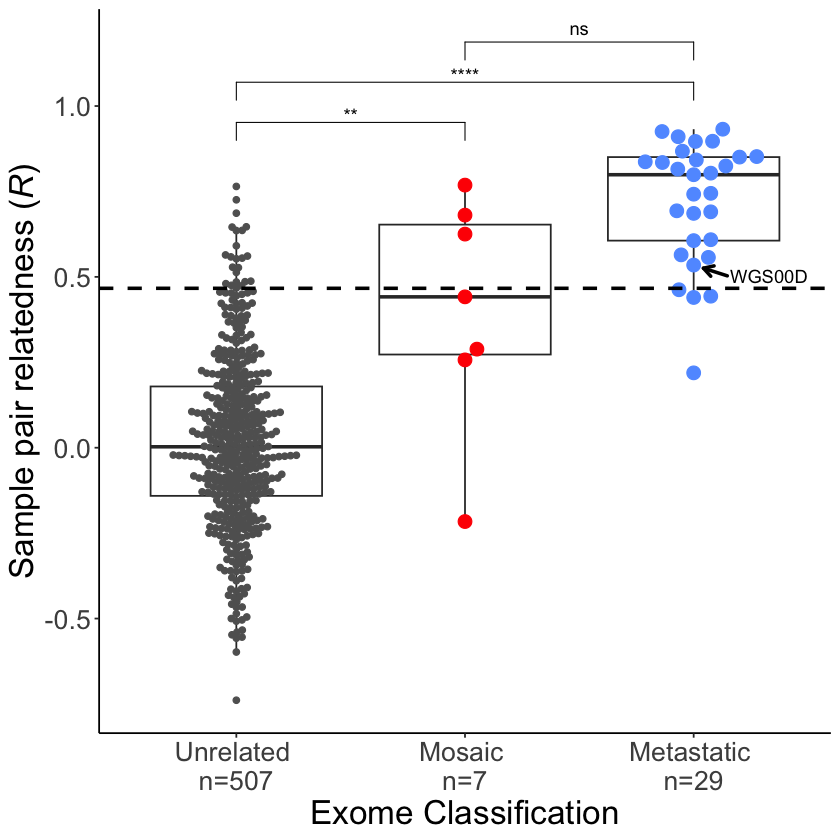

In [11]:
cor_annotated  %>% 
    filter(str_detect(cohort, "MGH"), `NGS \nClassification`!="independent", patient!="CC001"|is.na(patient))  %>% 
    mutate(`NGS \nClassification`=case_when(`NGS \nClassification`=="Interpatient MGH"~ "Unrelated", 
                                            `NGS \nClassification`=="mosaic" ~ "Mosaic",
                                            `NGS \nClassification`=="metastatic" ~ "Metastatic",
                                         TRUE ~ `NGS \nClassification`))  %>% 
    mutate(
        `NGS \nClassification` = as.factor(`NGS \nClassification`),
        `NGS \nClassification` =
            fct_relevel(`NGS \nClassification`, list("Unrelated", "Mosaic", "Metastatic"))
    ) %>%
    ggplot(aes(`NGS \nClassification`, cor)) +
    geom_blank() +
    geom_boxplot(data=.  %>%  filter(cohort!="Interpatient MGH"),
                 outlier.alpha=0) +
    geom_beeswarm(data=.  %>%  filter(cohort!="Interpatient MGH"),
                  aes(color=`NGS \nClassification`
                     ), cex=2.5, size=3.5) + 
    geom_boxplot(data=.  %>%  filter(cohort=="Interpatient MGH"),
                  outlier.alpha=0) +
    geom_beeswarm(
        data = . %>% filter(cohort == "Interpatient MGH"),
        color = "grey38", cex = 0.85
    ) +
    geom_text_repel(data=.%>% filter(patient=="WGS00D"), aes(label=patient), 
        point.padding = 0.7, 
        nudge_x = .33,
        nudge_y = -0.033,
        #segment.curvature = -1e-10,
        #segment.ncp = 3,
        #segment.angle = 90,
        arrow = arrow(length = unit(0.015, "npc")),
        segment.size = 1,
        ) +
    geom_hline(yintercept = cutoff, linetype=2, size=1) +
    scale_color_manual(values = c("red", "#619CFF"), guide = "none") +
    stat_pvalue_manual(dunn, step.increase = 0.05) +
    labs(x = "Exome Classification", y = "Sample pair relatedness (*R*)") +
    scale_x_discrete(labels=c("Unrelated \nn=507", "Mosaic \nn=7", "Metastatic \nn=29")) +
    theme_classic() +
    theme(text = element_text(size = 20), axis.title.y = ggtext::element_markdown()) 

ggsave("../plots/Fig3b.pdf")

Finding percentiles (5th percentile, median, 95th percentile):

Metastatic:

In [12]:
cor_annotated %>%
    filter(`NGS \nClassification` == "metastatic") %>%
    ungroup() %>% 
    summarize(q05=quantile(cor, 0.05), , median=quantile(cor, 0.5), q95=quantile(cor, 0.95))

q05,median,q95
<dbl>,<dbl>,<dbl>
0.4412324,0.7989771,0.9193391


Independent:

In [13]:
cor_annotated %>%
    filter(cohort == "Interpatient MGH") %>%
    ungroup() %>% 
    summarize(q05=quantile(cor, 0.05), median=quantile(cor, 0.5), q95=quantile(cor, 0.95), mean=mean(cor))

q05,median,q95,mean
<dbl>,<dbl>,<dbl>,<dbl>
-0.41239,0.002706349,0.4665308,0.01778661


Mosaic:

In [14]:
cor_annotated %>%
    filter(`NGS \nClassification` == "mosaic") %>%
    ungroup() %>% 
    summarize(q05=quantile(cor, 0.05), , median=quantile(cor, 0.5), q95=quantile(cor, 0.95))

q05,median,q95
<dbl>,<dbl>,<dbl>
-0.07415049,0.4415329,0.7422278
